## Part 1: feature stack creation and saving

In [1]:
# necessary packages for feature stack
import numpy as np
from scipy import ndimage

import matplotlib.pyplot as plt

from skimage import filters, feature, io
from skimage.morphology import disk,ball

# from sklearn.ensemble import RandomForestClassifier

import os
import imageio
import sys
import dask
import dask.array
# import cupy as cp
# import cucim
from itertools import combinations_with_replacement
import xarray as xr

### 1.1 feature functions

In [2]:
# functions take chunked dask-array as input


def nd_gaussian(da, sig = 0):
    if np.abs(sig-0)<0.1:
        G = np.array(da)
        fullname = 'original'
    else:
        deptharray = np.ones(da.ndim)+4*sig
        deptharray = tuple(np.min([deptharray, da.shape], axis=0))
        G = da.map_overlap(filters.gaussian, depth=deptharray, boundary='nearest', sigma = sig).compute()
        # G = da.map_overlap(filters.gaussian, depth=4*sig+1, boundary='none', sigma = sig).compute()
        fullname = ''.join(['gaussian_4D_',f'{sig:.1f}'])
    return G, fullname

def nd_gaussian_space(da, sig = 0):
    if np.abs(sig-0)<0.1:
        G = np.array(da)
        fullname = 'original_space'
        #TODO: remove sig = 0
    else:
        deptharray = np.ones(da.ndim)+4*sig
        deptharray = tuple(np.min([deptharray, da.shape], axis=0))
        G = da.map_overlap(filters.gaussian, depth=deptharray, boundary='nearest', sigma = (sig,sig,sig,0)).compute()
        # G = da.map_overlap(filters.gaussian, depth=4*sig+1, boundary='none', sigma = sig).compute()
        fullname = ''.join(['gaussian_space_',f'{sig:.1f}'])
    return G, fullname

def nd_gaussian_time(da, sig = 0):
    if np.abs(sig-0)<0.1:
        G = np.array(da)
        fullname = 'original_time'
        #TODO: remove sig = 0
    else:
        deptharray = np.ones(da.ndim)+4*sig
        deptharray = tuple(np.min([deptharray, da.shape], axis=0))
        G = da.map_overlap(filters.gaussian, depth=deptharray, boundary='nearest', sigma = (0,0,0,sig)).compute()
        # G = da.map_overlap(filters.gaussian, depth=4*sig+1, boundary='none', sigma = sig).compute()
        fullname = ''.join(['gaussian_time_',f'{sig:.1f}'])
    return G, fullname

#TODO create a class that makes the feature stacks and allows chosing suitable backends, e.g. dask, cupy, cucim etc.
def nd_gaussian_stack(da, sigmas):
    fullnames = []
    gstack = np.zeros(list(da.shape) + [len(sigmas)])
    for sig,i in zip(sigmas, range(len(sigmas))):
        gstack[...,i], name = nd_gaussian(da, sig)
        fullnames.append(name)
    return gstack, fullnames

def nd_gaussian_stack_space(da, sigmas):
    fullnames = []
    gstack = np.zeros(list(da.shape) + [len(sigmas)])
    for sig,i in zip(sigmas, range(len(sigmas))):
        gstack[...,i], name = nd_gaussian_space(da, sig)
        fullnames.append(name)
    return gstack, fullnames

def nd_gaussian_stack_time(da, sigmas):
    fullnames = []
    tgstack = np.zeros(list(da.shape) + [len(sigmas)])
    for sig,i in zip(sigmas, range(len(sigmas))):
        tgstack[...,i], name = nd_gaussian_time(da, sig)
        fullnames.append(name)
    return tgstack, fullnames

In [3]:
def nd_diff_of_gaussian(gstack, sigmas, mode='space'):
#     #creates a stack of {size} (see below)
    n = len(sigmas)
    size = int(n*(n-1)/2)
    dstack = np.zeros(list(da.shape) + [size])
    fullnames = []
    cc = 0
    for i in range(1,n):
        for j in range(i):
            dstack[...,cc] = gstack[...,i] - gstack[...,j]
            name = ''.join(['diff_of_gauss_',mode,'_',f'{sigmas[i]:.1f}','_',f'{sigmas[j]:.1f}'])
            fullnames.append(name)
            cc = cc + 1
    return dstack, fullnames

In [4]:
def ball_4d(sig):
    bnd = np.zeros((sig*2+1,sig*2+1,sig*2+1,sig*2+1), dtype = bool)
    bnd[sig,sig,sig,sig] = True
    ecd = ndimage.distance_transform_edt(~bnd)
    bnd = (ecd<sig+0.01).astype(int)
    return bnd

def nd_rank_like_filter(da, sigma, option):
    """
     input
     da - chunked das array up to 4D
     sigma - kernel size, scalar
     option, str ('minimum', 'maximum', 'median')
    """
    if da.ndim == 2:
        fp = disk(sigma)
    if da.ndim == 3:
        fp = ball(sigma)
    if da.ndim == 4:
        fp = ball_4d(sigma)
        
    if option == 'minimum':
        fun = ndimage.minimum_filter
    elif option == 'maximum':
        fun = ndimage.maximum_filter
    elif option == 'median':
        fun = ndimage.median_filter
    else:
        print(option+' not available')
    deptharray = np.ones(da.ndim)+sigma
    deptharray = tuple(np.min([deptharray, da.shape], axis=0))
    M = da.map_overlap(fun, depth=deptharray, footprint=fp).compute()
    # M = da.map_overlap(fun, depth=sigma+1, footprint=fp).compute()
    fullname = ''.join([option,'_',f'{sigma:.1f}'])
    return M, fullname

def nd_rank_like_stack(da, sigmas, option):
    fullnames = []
    mstack = np.zeros(list(da.shape) + [len(sigmas)-1])
    for sig,i in zip(sigmas[1:], range(len(sigmas)-1)):
        mstack[...,i], name = nd_rank_like_filter(da, sig, option)
        fullnames.append(name)
    return mstack, fullnames   
    

In [17]:
def nd_dynamic_rank_filter(da, sigma_3D, sigma_t, option):
    """
    same as rank filters above, but considering much larger range in time
    TODO: add clever option with dynmaic model, maybe sigmoid-fit, oscillation, inverse-sigmoid, etc.
    """
    fp_3D = ball(sigma_3D)
    fp_4D = np.zeros(list(fp_3D.shape)+[2*sigma_t], dtype=int)
    fp_4D[fp_3D>0,:] = 1
    
    if option == 'minimum':
        fun = ndimage.minimum_filter
    elif option == 'maximum':
        fun = ndimage.maximum_filter
    elif option == 'median':
        fun = ndimage.median_filter
    else:
        print(option+' not available')
    
    deptharray = np.ones(da.ndim)+sigma_3D
    deptharray[-1] = sigma_t
    deptharray = tuple(np.min([deptharray, da.shape], axis=0))
    
    M = da.map_overlap(fun, depth=deptharray, footprint=fp_4D).compute()
    fullname = ''.join(['dynamic_',option,'_',f'{sigma_3D:.1f}','_',f'{sigma_t:.1f}'])
    return M, fullname

def nd_dynamic_rank_like_stack(da, sigmas, option, sigma_t=20):
    fullnames = []
    mstack = np.zeros(list(da.shape) + [len(sigmas)])
    for sig,i in zip(sigmas, range(len(sigmas))):
        mstack[...,i], name = nd_dynamic_rank_filter(da, sig, sigma_t, option)
        fullnames.append(name)
    return mstack, fullnames  
        
    
def diff_to_first_and_last(da):
    fullnames = ['diff_first', 'diff_last']
    stack = np.zeros(list(da.shape) + [2])
    # stack[...,0] = da[...,:] - da[...,0][...,None]
    # stack[...,1] = da[...,:] - da[...,-1][...,None]
    # above does not work with lazy loaded xarray/dask arrays, probably the None-thing
    # maybe somehow possible to avoid for-loop
    for t in range(da.shape[-1]):
        stack[:,:,:,t,0] = da[:,:,:,t] - da[:,:,:,0]
        stack[:,:,:,t,1] = da[:,:,:,t] - da[:,:,:,-1]
    
    return stack, fullnames
    
    

In [6]:
def nd_Hessian_matrix(G):
    """
    copied from skimage.feature.hessian_matrix
    just directly using Gaussian fitered arrays and dask
    """
    
    daG = dask.array.from_array(G)
    gradients = dask.array.gradient(daG)
    axes = range(G.ndim)
    gradients = [gradients[ax0].compute() for ax0 in axes]
    H_elems = [dask.array.gradient(gradients[ax0], axis=ax1).compute() for ax0, ax1 in combinations_with_replacement(axes, 2)]
    elems = [(ax0,ax1) for ax0, ax1 in combinations_with_replacement(axes, 2)]
    return H_elems, elems, gradients

def nd_Hessian_stack(G, sigma):
    H_elems, elems, gradients = nd_Hessian_matrix(G)
    hstack = np.zeros(list(G.shape)+[len(elems)])
    gradstack = np.zeros(list(G.shape)+[len(gradients)])
    
    #TODO: this is slow, find some better numpy function
    gradnames = []
    for i in range(len(elems)):
        hstack[...,i] = H_elems[i]
    for i in range(len(gradients)):
        gradnames.append(''.join(['gradient_',str(i),'_',f'{sigma:.1f}']))
        gradstack[...,i] = gradients[i]
    
    # print('got Hessian matrices, now doing the eigs')
    # eigs = feature.hessian_matrix_eigvals(H_elems) 
 # for now ignore the eigenvalues (too computationally expensive and H_elems already contains the image curvature  

    fullnames = []
    for i,j in elems:
        fullname = ''.join(['hessian_',str(i),str(j),'_',f'{sigma:.1f}'])
        fullnames.append(fullname) 
    
    stack = np.concatenate([hstack,gradstack], axis=-1)
    fullnames = fullnames+gradnames                         
        
    return stack, fullnames

def nd_Hessian_stacks(gstack, sigmas):
    flag = True
    fullnames = []
    for (i, sigma) in zip(range(gstack.shape[-1]), sigmas):
        a, b = nd_Hessian_stack(gstack[...,i], sigma)
        asize = a.shape[-1]
        if flag:
            flag = False
            hstacks = np.zeros(list(gstack[...,-1].shape)+[len(sigmas)*asize])
        hstacks[...,i*asize:i*asize+asize] = a
        fullnames = fullnames + b
    return hstacks, fullnames

In [7]:
# come up for a "dynamic" feature in the time domain, e.g. sig-fit per pixel and per small subvolume like rank-filters
# TODO: include time-specific stacks

def nd_feature_Stack(da, sigmas, feat_select):
#     TODO: make more elegant
    
    fstack = []
    featnames = []
    
    print('compare to first and last scan')
    stack, names = diff_to_first_and_last(da)
    fstack.append(stack)
    featnames = featnames + names
        
    
    if feat_select['extra_time_ranks']:
        print('do rank filters with extension in time')
        tmaxstack, tmaxnames = nd_dynamic_rank_like_stack(da, sigmas, option='maximum')
        featnames = featnames + tmaxnames
        fstack.append(tmaxstack)

        tminstack, tminnames = nd_dynamic_rank_like_stack(da, sigmas, option='minimum')
        featnames = featnames + tminnames
        fstack.append(tminstack)

        tmedstack, tmednames = nd_dynamic_rank_like_stack(da, sigmas, option='median')
        featnames = featnames + tmednames
        fstack.append(tmedstack)
    
    print('apply Gaussian filters anyway')
    gstack, gnames = nd_gaussian_stack(da, sigmas)

    if feat_select['Gaussian']:
        featnames = featnames + gnames
        fstack.append(gstack)
        
        print('space gaussians')
        sgstack, sgnames = nd_gaussian_stack_space(da, sigmas)
        featnames = featnames + sgnames
        fstack.append(sgstack)
        
        print('time gaussians')
        tgstack, tgnames = nd_gaussian_stack_time(da, sigmas)
        featnames = featnames + tgnames
        fstack.append(tgstack)
        
    if feat_select['Hessian']:
        print('get Hessian matrices')
        hstack, hnames = nd_Hessian_stacks(gstack, sigmas)
        featnames = featnames + hnames 
        fstack.append(hstack)
        
    if feat_select['Diff of Gaussians']:
        print('get differences of Gaussians')
        dstack, dnames = nd_diff_of_gaussian(gstack, sigmas)
        featnames = featnames + dnames
        fstack.append(dstack)
        
        print('space gaussians')
        dsstack, dsnames = nd_diff_of_gaussian(sgstack, sigmas)
        featnames = featnames + dsnames
        fstack.append(dsstack) 
        
        print('time gaussians')
        dtstack, dtnames = nd_diff_of_gaussian(tgstack, sigmas, mode='time')
        featnames = featnames + dtnames
        fstack.append(dtstack)
        
    if feat_select['maximum']:
        print('apply maximum filters')
        maxstack, maxnames = nd_rank_like_stack(da, sigmas, option='maximum')
        featnames = featnames + maxnames
        fstack.append(maxstack)
        
    if feat_select['median']:
        print('apply median filters')
        medstack, mednames = nd_rank_like_stack(da, sigmas, option='median')
        featnames = featnames + mednames
        fstack.append(medstack)
        
    if feat_select['minimum']:
        print('apply minimum filters')
        minstack, minnames = nd_rank_like_stack(da, sigmas, option='minimum')
        featnames = featnames + minnames
        fstack.append(minstack)

    print('concatenate feature stack and return')
    print('this command loads everything into memory, watch out!')
    return np.concatenate(fstack, axis=-1), featnames #this command loads everything into memory, watch out!

def feat_stack_to_nc(fstack, featnames, path = None):
    #TODO: include metadata and make general, now only 4D possible
    data = xr.Dataset({'feature_stack': (['x','y','z','time', 'feature'], fstack)},
                       coords = {'x': np.arange(fstack.shape[0]),
                                 'y': np.arange(fstack.shape[1]),
                                 'z': np.arange(fstack.shape[2]),
                                 'time': np.arange(fstack.shape[3]),
                                 'feature': featnames}
                      # attrs = feat_select)
                     )
    # data.attrs['name'] = name
    if path is not None:
        data.to_netcdf(path)
    return data
    

### 1.2 load 4D dataset into dask-array TODO: employ datastreaming for datasets that are too large

In [8]:
#TODO
da = None
raw_data = None

In [9]:
## load some yarn data
# raw_data = xr.load_dataset('/home/fische_r/NAS/testing/Jeremy_tomo/tomodata.nc')
# raw_data = xr.load_dataset('/mpc/homes/fische_r/wood/wood_tomo.nc')

In [10]:
# da = dask.array.from_array(raw_data['tomo'].data, chunks= '20 MiB')

In [46]:
chunkshape = {'x': 65, 'y': 70, 'z': 70, 'time':8}

In [211]:
ds = xr.open_dataset('/home/fische_r/NAS/testing/Jeremy_tomo/tomo_large.nc', chunks='auto')

In [213]:
ds.close()

In [212]:
da = dask.array.from_array(ds.tomo).rechunk(chunks = '20 MiB')

In [209]:
da = da.rechunk(chunks = '20 MiB')

In [216]:
da.name

'rechunk-merge-bd2dc9cae5ade908c2f96cc0e8de11d9'

In [215]:
da.

dask.array<rechunk-merge, shape=(65, 70, 1260, 8), dtype=float64, chunksize=(65, 35, 315, 2), chunktype=xarray.DataArray>

### 1.3 feature settings

In [51]:
sigmas = [0, 2,4]#, 8]  #hard-coded for now, sobel and hessian require that first sigma is 0, diff, gaussian(sig=0) = 0

# default feature choice
feat_select = {'Gaussian': True, 
               # 'Sobel': True,
               'Hessian': True,
               'Diff of Gaussians': True,
               'maximum': True,
               'minimum': True,
               'median': True,
               'extra_time_ranks': True
              }

In [52]:
training_dict = {}

### 1.4 Create and store feature stack

In [55]:
#output path
# outpath = '/mpc/homes/fische_r/wood/feat_stack.nc'
outpath = '/home/fische_r/NAS/testing/Jeremy_tomo/featstack_large.nc'

In [54]:
#this may take a while depending on the size and system
# may even crash because out of memory

fstack, featnames = nd_feature_Stack(da, sigmas, feat_select)

compare to first and last scan
do rank filters with extension in time
apply Gaussian filters anyway
space gaussians
time gaussians
get Hessian matrices
get differences of Gaussians
space gaussians
time gaussians
apply maximum filters
apply median filters
apply minimum filters
concatenate feature stack and return
this command loads everything into memory, watch out!


In [56]:
feat_data = feat_stack_to_nc(fstack, featnames, outpath)

In [57]:
fstack = None
data = None

In [58]:
feat_data['feature_stack'].size/1024**3

3.2889917492866516

In [53]:
feat_backup = feat_data.copy()

In [28]:
feat_data['feature']

<xarray.DataArray 'feature' (feature: 77)>
array(['dynamic_maximum_0.0_20.0', 'dynamic_maximum_2.0_20.0',
       'dynamic_maximum_4.0_20.0', 'dynamic_minimum_0.0_20.0',
       'dynamic_minimum_2.0_20.0', 'dynamic_minimum_4.0_20.0',
       'dynamic_median_0.0_20.0', 'dynamic_median_2.0_20.0',
       'dynamic_median_4.0_20.0', 'original', 'gaussian_4D_2.0',
       'gaussian_4D_4.0', 'original_space', 'gaussian_space_2.0',
       'gaussian_space_4.0', 'original_time', 'gaussian_time_2.0',
       'gaussian_time_4.0', 'hessian_00_0.0', 'hessian_01_0.0',
       'hessian_02_0.0', 'hessian_03_0.0', 'hessian_11_0.0', 'hessian_12_0.0',
       'hessian_13_0.0', 'hessian_22_0.0', 'hessian_23_0.0', 'hessian_33_0.0',
       'gradient_0_0.0', 'gradient_1_0.0', 'gradient_2_0.0', 'gradient_3_0.0',
       'hessian_00_2.0', 'hessian_01_2.0', 'hessian_02_2.0', 'hessian_03_2.0',
       'hessian_11_2.0', 'hessian_12_2.0', 'hessian_13_2.0', 'hessian_22_2.0',
       'hessian_23_2.0', 'hessian_33_2.0', 'gradient_0_2.0', 'gradient_1_2.0',
       'gradient_2_2.0', 'gradient_3_2.0', 'hessian_00_4.0', 'hessian_01_4.0',
       'hessian_02_4.0', 'hessian_03_4.0', 'hessian_11_4.0', 'hessian_12_4.0',
       'hessian_13_4.0', 'hessian_22_4.0', 'hessian_23_4.0', 'hessian_33_4.0',
       'gradient_0_4.0', 'gradient_1_4.0', 'gradient_2_4.0', 'gradient_3_4.0',
       'diff_of_gauss_space_2.0_0.0', 'diff_of_gauss_space_4.0_0.0',
       'diff_of_gauss_space_4.0_2.0', 'diff_of_gauss_space_2.0_0.0',
       'diff_of_gauss_space_4.0_0.0', 'diff_of_gauss_space_4.0_2.0',
       'diff_of_gauss_time_2.0_0.0', 'diff_of_gauss_time_4.0_0.0',
       'diff_of_gauss_time_4.0_2.0', 'maximum_2.0', 'maximum_4.0',
       'median_2.0', 'median_4.0', 'minimum_2.0', 'minimum_4.0', 'minimum_2.0',
       'minimum_4.0'], dtype='<U27')
Coordinates:
  * feature  (feature) <U27 'dynamic_maximum_0.0_20.0' ... 'minimum_4.0'

In [61]:
feat_data['feature'][6]

<xarray.DataArray 'feature' ()>
array('original', dtype='<U27')
Coordinates:
    feature  <U27 'original'

## Part 2: Training the classifier

In [22]:
# necessary packages

#reload after kernel reset
import xarray as xr
import os
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

#the classifier
from sklearn.ensemble import RandomForestClassifier
#stuff for painting on the image
from ipywidgets import Image
from ipywidgets import ColorPicker, IntSlider, link, AppLayout, HBox
from ipycanvas import  hold_canvas,  MultiCanvas #RoughCanvas,Canvas,

### 2.1 open (not load) feature stack

In [25]:
featpath = outpath
trainingpath = '/home/fische_r/NAS/testing/Jeremy_tomo/label_images'
# feat_data = xr.open_dataset(featpath)
feat_names = feat_data['feature'].data

### 2.2 training functions

In [29]:
def extract_training_data(truth, feat_stack):
    #pixelwise training data
    phase1 = truth==1
    phase2 = truth==2
    phase3 = truth==4   
    X1 = feat_stack[phase1]
    y1 = np.zeros(X1.shape[0])
    X2 = feat_stack[phase2]
    y2 = np.ones(X2.shape[0])
    X3 = feat_stack[phase3]
    y3 = 2*np.ones(X3.shape[0])

    y = np.concatenate([y1,y2,y3])
    X = np.concatenate([X1,X2,X3])
    
    return X,y

In [30]:
 def classify(X,y,im, feat_stack):
    # TODO: allow choice and manipulation of ML method
    clf =  RandomForestClassifier(n_estimators = 300, n_jobs=-1, random_state = 42, max_features=None) 
    clf.fit(X, y)
    num_feat = feat_stack.shape[-1]
    ypred = clf.predict(feat_stack.reshape(-1,num_feat))
    result = ypred.reshape(im.shape).astype(np.uint8)
    return result, clf

In [31]:
def training_function(im, truth, feat_stack, training_dict, slice_name):
    flag = False
    slices = list(training_dict.keys())
    if slice_name in slices: 
        slices.remove(slice_name)
    if len(slices)>0:
        flag = True
        Xall = training_dict[slices[0]][0]
        yall = training_dict[slices[0]][1]
        for i in range(1,len(slices)):
            Xall = np.concatenate([Xall, training_dict[slices[i]][0]])
            yall = np.concatenate([yall, training_dict[slices[i]][1]])
            
    X,y = extract_training_data(truth, feat_stack)
    
    print('training and classifying')
    
    if flag:
        Xt = np.concatenate([Xall,X])
        yt = np.concatenate([yall,y])
        Xall = None
        yall = None
    else:
        Xt = X
        yt = y  
    result, clf = classify(Xt, yt, im, feat_stack)
    
    # store training data of current slice in dict
    training_dict[slice_name] = (X,y)
    return result, clf, training_dict

### 2.3 select 2D-slice and create a training set

In [32]:
# randomly suggest slice for training
# TODO: take coordinates from feat_data
dimensions = ['x','y','z','time']

test_dims = np.random.choice(dimensions, 2, replace=False)
p1 = np.random.choice(range(len(feat_data[test_dims[0]])))
p2 = np.random.choice(range(len(feat_data[test_dims[1]])))

print('You could try ',test_dims[0],'=',p1,' and ',test_dims[1],'=',p2)
# ts = np.random.choice(range(num_ts))+1
# print('try time step ',ts )

You could try  y = 30  and  x = 92


In [1169]:
#select 2D slice orthogonal to these two axes
#replace dimensions in .sel accordingly, d1c and d2c are needed for filename
#TODO: make more elegant
d1c = 'y'
d2c = 'time'
p1c = 20
p2c = 22

# im = feat_data['feature_stack'].sel(z = p1c, time = p2c, feature='original').data
im = feat_data['feature_stack'][...,6].sel(y = p1c, time = p2c).data
# im8 = np.uint8(im)
feat_stack = feat_data['feature_stack'].sel(y = p1c, time = p2c).data

In [1170]:
# imdry = feat_data['feature_stack'].sel(z = p1c, time = 0, feature='original').data
imdry = feat_data['feature_stack'][...,6].sel(y = p1c, time = 0).data
diff = im-imdry
diff = diff/diff.max()*255
diff[diff<0]=0
diff[diff>255] = 255

# imdry = imdry-imdry.min()
imdry = imdry/imdry.max()*255
# imdry = imdry-50
# imdry[imdry<0]=0
# imdry=imdry*255/150
# imdry[imdry>255] = 255

im8 = im-im.min()
im8 = np.uint8(im8/im8.max()*225)
# im8 = im8-50
# im8[im8<0]=0
# im8=im8*255/250
im8[im8>254] = 254
# im8old = im8.copy()

In [1171]:
slice_name = ''.join([str(d1c),str(p1c),str(d2c),str(p2c)])
truthpath = os.path.join(trainingpath, ''.join(['label_image_',slice_name,'.tif']))

resultim = np.zeros(im.shape, dtype=np.uint8)
if os.path.exists(truthpath):
    truth = io.imread(truthpath)
    print('existing label set loaded')
else:
    truth = resultim.copy()

### 2.4 training interface
currently only 3 phases possible <br />
manually specify #ff000 (phase 1) #00ff00 (phase 2) or #0000ff (phase 3) as color and paint

#### 2.4.1 label data

In [1183]:
width = im8.shape[1]
height = im8.shape[0]

Mcanvas = MultiCanvas(4, width=width, height=height)
background = Mcanvas[0]
resultdisplay = Mcanvas[2]
truthdisplay = Mcanvas[1]
canvas = Mcanvas[3]
canvas.sync_image_data = True

drawing = False
position = None
shape = []

def on_mouse_down(x, y):
    global drawing
    global position
    global shape

    drawing = True
    position = (x, y)
    shape = [position]

def on_mouse_move(x, y):
    global drawing
    global position
    global shape

    if not drawing:
        return

    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)

        position = (x, y)

    shape.append(position)

def on_mouse_up(x, y):
    global drawing
    global positiondu
    global shape

    drawing = False

    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        canvas.fill_polygon(shape)

    shape = []

image_data = np.stack((im8, im8, im8), axis=2)
# image_data = np.stack((diff*2, diff*2, diff*2), axis=2)
background.put_image_data(image_data, 0, 0)

resultdisplay.global_alpha = 0.15
if np.any(resultim>0):
    result_data = np.stack((255*(resultim==0), 255*(resultim==1), 255*(resultim==2)), axis=2)
else:
    result_data = np.stack((0*resultim, 0*resultim, 0*resultim), axis=2)
resultdisplay.put_image_data(result_data, 0, 0)

canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)

# canvas.stroke_style = "#749cb8"
# canvas.global_alpha = 0.75

picker = ColorPicker(description="Color:", value="#ff0000")
slidealpha = IntSlider(description="Result overlay", value=0.15)

link((picker, "value"), (canvas, "stroke_style"))
link((picker, "value"), (canvas, "fill_style"))
# link((slidealpha, "value"), (resultdisplay, "global_alpha"))

HBox((Mcanvas, picker, slidealpha))
#print('paint image with #ff0000 for air, #00ff00 for water and #0000ff for fiber')

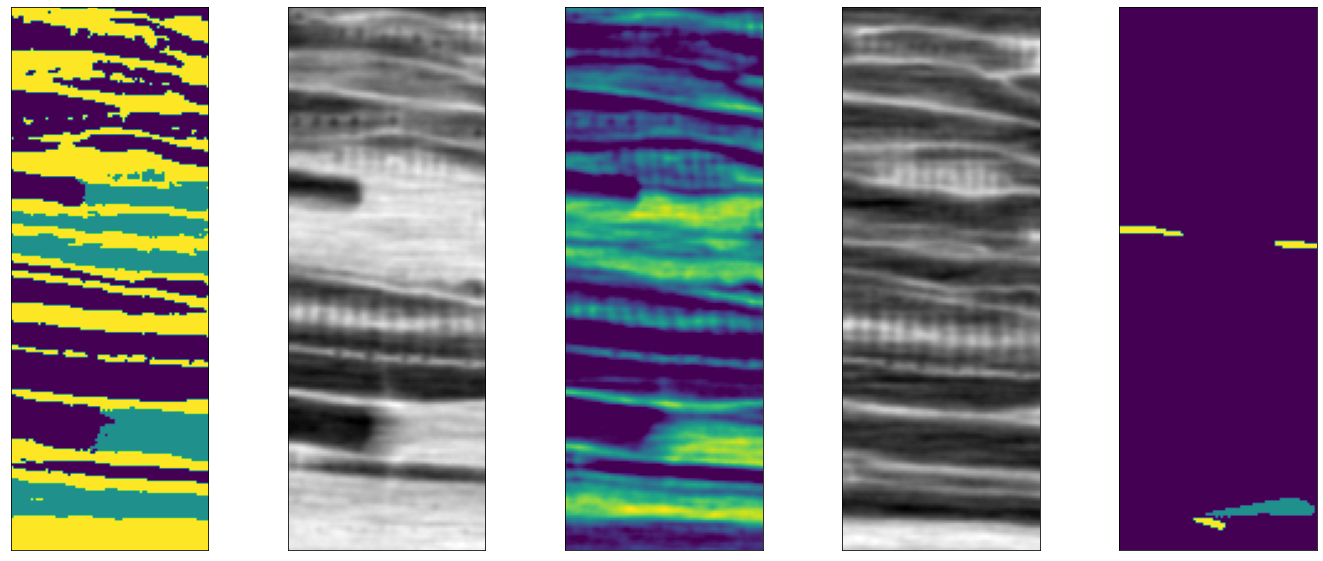

In [1184]:
diff[diff<0] = 0
fig, axes = plt.subplots(1,5, figsize=(24,10))
axes[0].imshow(resultim)
axes[1].imshow(im8, 'gray')
axes[2].imshow(diff)
# axes[3].imshow(m8old, 'gray')
axes[3].imshow(imdry, 'gray')
axes[4].imshow(truth)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

In [1185]:
#create truth image from image, save to file
label_set = canvas.get_image_data()

truth[label_set[:,:,0]>0] = 1
truth[label_set[:,:,1]>0] = 2
truth[label_set[:,:,2]>0] = 4

imageio.imsave(truthpath, truth)

#### 2.4.2 actual training

In [1186]:
resultim, clf, training_dict = training_function(im, truth, feat_stack, training_dict, slice_name)

training and classifying


#### 2.4.3 iterative training: go back to 2.4.1 until good segmentation or try different slice at 2.3

#### 2.4.4 plot classifier properties

/tmp/ipykernel_28241/1483009324.py:2: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(feat_names,clf.feature_importances_,'x')


Text(0, 0.5, 'importance')

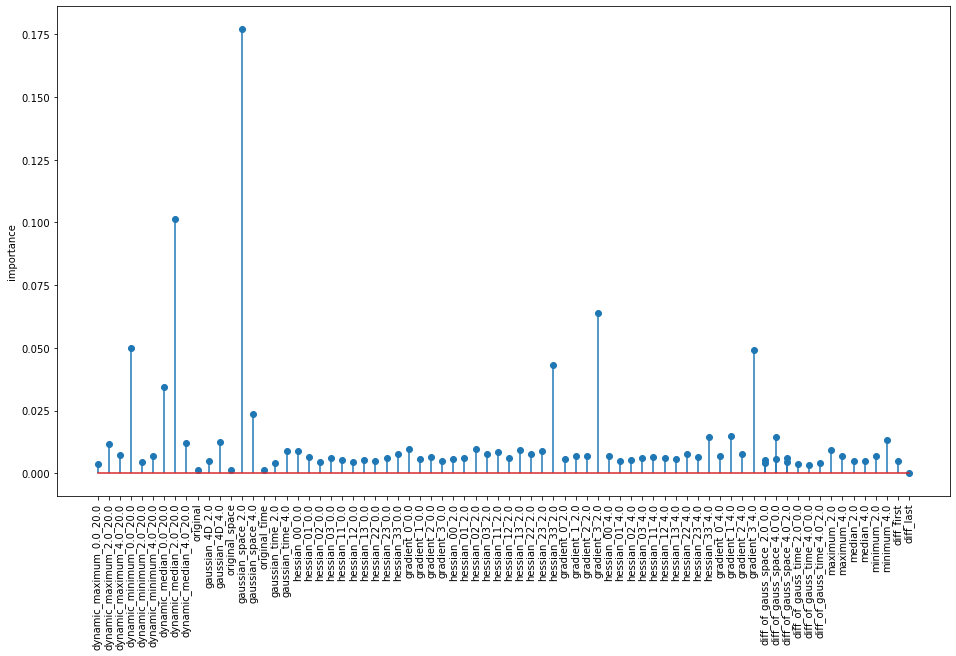

In [80]:
plt.figure( figsize=(16,9))
plt.stem(feat_names,clf.feature_importances_,'x')
plt.xticks(rotation=90)
plt.ylabel('importance')

### Re-train with all label iamges and new feature stack

In [27]:
def tmp_extract_coords(label_name):
    coord1 = label_name[12]
    coord2 = 'time'
    for i in range(len(label_name)):
        if label_name[i:i+4] == 'time':
            p1 = int(label_name[13:i])
            p2 = int(label_name[i+4:-4])
    return coord1, p1, coord2, p2

def training_set_per_image(label_name, trainingpath, feat_data):
    c1, p1, c2, p2 = tmp_extract_coords(label_name)
    # print(label_name)
    # print(c1, p1, c2, p2)
    truth = io.imread(os.path.join(trainingpath, label_name))
    
    # temporary workaround, make general
    if c1 == 'x' and c2 == 'time':
        feat_stack = feat_data['feature_stack'].sel(x = p1, time = p2).data
    elif c1 == 'y' and c2 == 'time':
        feat_stack = feat_data['feature_stack'].sel(y = p1, time = p2).data
    elif c1 == 'z' and c2 == 'time':
        feat_stack = feat_data['feature_stack'].sel(z = p1, time = p2).data
    else:
        print('coordinates not found')
    
    X, y = extract_training_data(truth, feat_stack)
    return X,y
    
        
    

def retrain_new_feat(trainingpath, feat_data):
    training_dict = {}
    labelnames = os.listdir(trainingpath)
    flag = True
    for label_name in labelnames:
        X, y = training_set_per_image(label_name, trainingpath, feat_data)
        training_dict[label_name] = X,y
        if flag:
            Xall = X
            yall = y
            flag = False
        else:
            Xall = np.concatenate([Xall,X])
            yall = np.concatenate([yall,y])
            
    clf =  RandomForestClassifier(n_estimators = 300, n_jobs=-1, random_state = 42, max_features=None) 
    clf.fit(Xall, yall)
    return clf, training_dict
    
    

In [34]:
clf, retraining_dict = retrain_new_feat(trainingpath, feat_data)

In [35]:
def classify_slice(feat_data, c1, p1, c2, p2):
    # temporary workaround, make general
    if c1 == 'x' and c2 == 'time':
        feat_stack = feat_data['feature_stack'].sel(x = p1, time = p2).data
        original = feat_data['feature_stack'].sel(x = p1, time = p2, feature='original').data
        imfirst = feat_data['feature_stack'].sel(x = p1, time = 0, feature='original').data
    elif c1 == 'y' and c2 == 'time':
        feat_stack = feat_data['feature_stack'].sel(y = p1, time = p2).data
        original = feat_data['feature_stack'].sel(y = p1, time = p2, feature='original').data
        imfirst = feat_data['feature_stack'].sel(y = p1, time = 0, feature='original').data
    elif c1 == 'z' and c2 == 'time':
        feat_stack = feat_data['feature_stack'].sel(z = p1, time = p2).data
        original = feat_data['feature_stack'].sel(z = p1, time = p2, feature='original').data
        imfirst = feat_data['feature_stack'].sel(z = p1, time = 0, feature='original').data
    else:
        print('coordinates not found')
    num_feat = len(feat_data['feature'])
    ypred = clf.predict(feat_stack.reshape(-1,num_feat))
    result = ypred.reshape(feat_stack.shape[:2]).astype(np.uint8)
    return result, original, imfirst
        
    
    

In [72]:
c1 = 'y'
p1 = 30
c2 = 'time'
p2 = 7

result_im, imorig, imdry = classify_slice(feat_data, c1, p1, c2, p2)



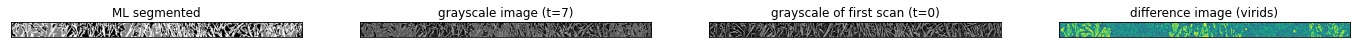

In [74]:
# impath = '/home/fische_r/NAS/testing/Jeremy_tomo/ML_result_example.png'
fig, axes = plt.subplots(1,4, figsize=(24,10))
axes[0].imshow(result_im, 'gray')
axes[0].set_title('ML segmented')
axes[1].imshow(imorig, 'gray', vmin=-2.5e-4, vmax=1.5e-3)
axes[1].set_title('grayscale image (t=7)')
# axes[3].imshow(m8old, 'gray')
axes[2].imshow(imdry, 'gray', vmin=-2.5e-4, vmax=1.5e-3)
axes[2].set_title('grayscale of first scan (t=0)')
diff = imorig-imdry
axes[3].imshow(diff,vmin=-7e-4, vmax=7e-4)
axes[3].set_title('difference image (virids)')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
# plt.savefig(impath, dpi=1000, bboxes = 'tight')

## 3 apply classifier to full data set

In [39]:
import pickle

In [40]:
pickle.dump(clf, open(os.path.join(trainingpath, 'clf.p'),'wb'))

In [41]:
def classify_all(clf, feat_stack):
    # TODO: allow choice and manipulation of ML method
    num_feat = feat_stack.shape[-1]
    ypred = clf.predict(feat_stack.reshape(-1,num_feat))
    result = ypred.reshape(feat_stack[...,0].shape).astype(np.uint8)
    return result

In [60]:
#load clf
clf = pickle.load(open(os.path.join(trainingpath, 'clf.p'),'rb'))

In [61]:
segdata = classify_all(clf, feat_data['feature_stack'].data)

In [62]:
segdata = xr.Dataset({'segmented': (['x','y','z','t'],segdata)},
                  coords = {'x': np.arange(segdata.shape[0]),
                            'y': np.arange(segdata.shape[1]),
                            'z': np.arange(segdata.shape[2]),
                            't': np.arange(segdata.shape[3])})

In [63]:
segoutpath = '/home/fische_r/NAS/testing/Jeremy_tomo/segmented_large.nc'
segdata.to_netcdf(segoutpath)

In [3]:
segoutpath = '/home/fische_r/NAS/testing/Jeremy_tomo/segmented_retrained.nc'
segdata = xr.open_dataset(segoutpath)

In [5]:
segdata.close()

126.0

Text(0, 0.5, 'y [px]')

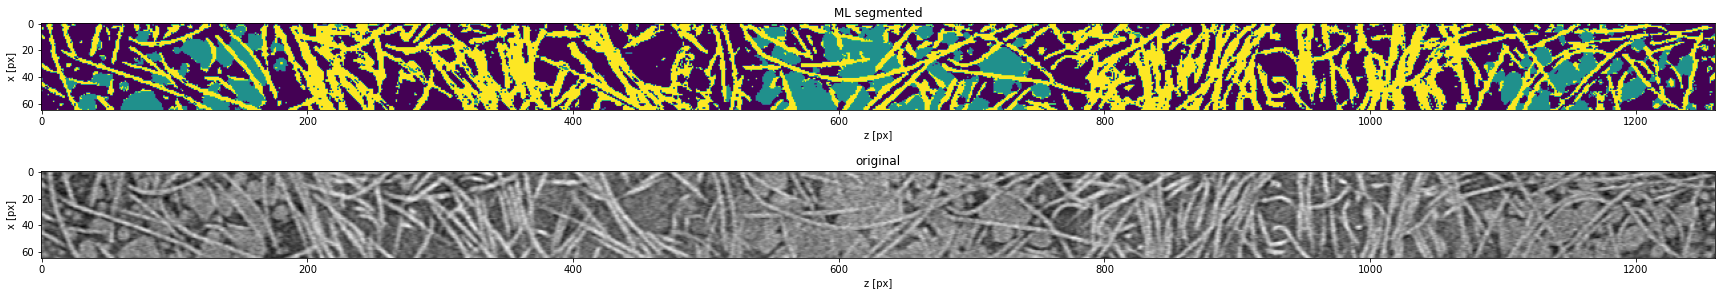

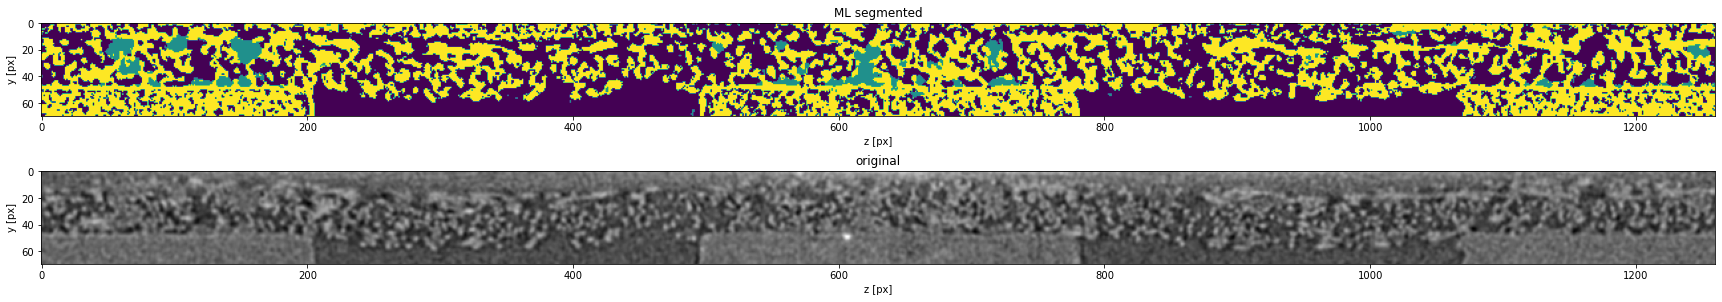

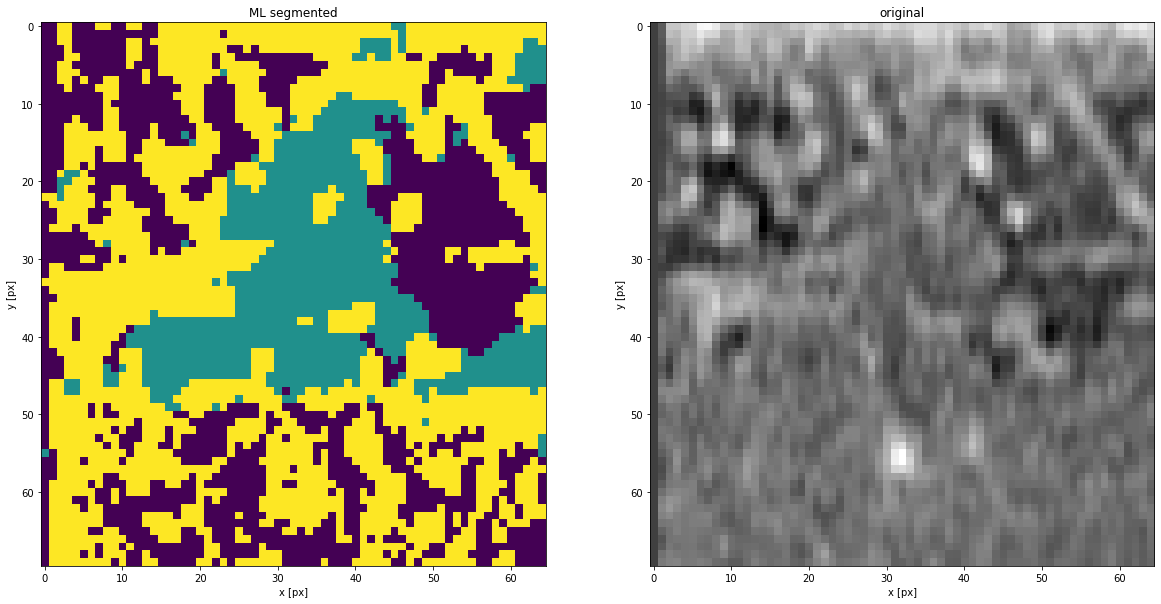

In [182]:

# y=10, t=0
xs = 25
ys = 45
zs = 615
ts = 5

fig, axes = plt.subplots(2,1, figsize=(30,5))
axes[0].imshow(segdata['segmented'].sel(y=ys, t=ts))
# segdata['segmented'].sel(y=ys, t=ts).plot(ax =axes[0], cmap='gray')
axes[1].imshow(feat_data['feature_stack'].sel(y=ys, time=ts, feature='original'), cmap='gray')
# feat_data['feature_stack'].sel(y=ys, time=ts, feature='original').plot(ax=axes[1], cmap='gray')
axes[0].set_title('ML segmented')
axes[1].set_title('original')
axes[0].set_xlabel('z [px]')
axes[1].set_xlabel('z [px]')
axes[0].set_ylabel('x [px]')
axes[1].set_ylabel('x [px]')

fig, axes = plt.subplots(2,1, figsize=(30,5))
axes[0].imshow(segdata['segmented'].sel(x=xs, t=ts))
axes[1].imshow(feat_data['feature_stack'].sel(x=xs, time=ts, feature='original'), cmap='gray')
axes[0].set_title('ML segmented')
axes[1].set_title('original')
axes[0].set_xlabel('z [px]')
axes[1].set_xlabel('z [px]')
axes[0].set_ylabel('y [px]')
axes[1].set_ylabel('y [px]')

fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(segdata['segmented'].sel(z=zs, t=ts).data.transpose(1,0)) #, cmap='gray'
axes[1].imshow(feat_data['feature_stack'].sel(z=zs, time=ts, feature='original').data.transpose(1,0), cmap='gray')
axes[0].set_title('ML segmented')
axes[1].set_title('original')
axes[0].set_xlabel('x [px]')
axes[1].set_xlabel('x [px]')
axes[0].set_ylabel('y [px]')
axes[1].set_ylabel('y [px]')
